[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

class Grid:
  
  def __init__(self,L=10,scale=5):
    self.shape = (scale*L, scale*L)
    self.agents = np.zeros(self.shape)
    self.agents[L:2*L,L:2*L] = 1
    self.template = np.zeros(self.shape)
    self.template[2*L:3*L,2*L:3*L] = 1
    
  def coordinates(self, which='agents'):
    if which == 'agents':
      return [(i,j) for i,row in enumerate(self.agents) for j,val in enumerate(row) if val==1]
    elif which == 'template':
      return [(i,j) for i,row in enumerate(self.template) for j,val in enumerate(row) if val==1]
    
  def plot(self):
    grid = np.zeros(self.shape)
    for p in self.coordinates('template'):
      grid[p]=0.5
    for p in self.coordinates('agents'):
      grid[p]=1
    plt.imshow(grid)
    plt.grid(False)
    plt.show()

In [0]:
g = Grid()

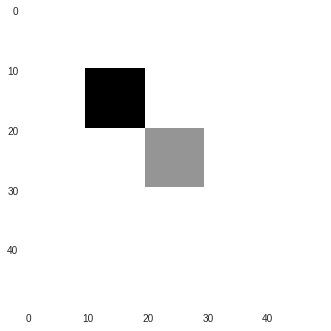

In [24]:
g.plot()

In [65]:
# instantiate agents at initial coordinates
# initialize estimated coordinates as true initial coordinates
# update_neighbors_and_distances()

agents = []

for x in range(gridshape[0]):
  for y in range(gridshape[1]):
    if grid[x,y]==1:
      agents.append({'true_coordinates':(x,y),
                     'estimated_coordinates':(x,y),
                     'orientation':(-1,0),
                     'id':len(agents),
                     'is_source':bool((x,y)==(2*L-1,2*L-1))
                    })

def distance_metric(a,b):
  return max(abs(a[0]-b[0]),abs(a[1]-b[1]))
  #return abs(a[0]-b[0])+abs(a[1]-b[1])

def in_radius(test_point,center,radius):
  out = False
  if distance_metric(test_point,center) <= radius:
    out = True
  return out

def get_neighbors_distances_estimations(agent,radius=1):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  distances = [distance_metric(agents[i]['true_coordinates'],center) for i in neighbors]
  estimated_coordinates = agent['estimated_coordinates']
  
  if len(neighbors)>0:
  
    neighbors_estimated_coordinates = [agents[n]['estimated_coordinates'] for n in neighbors]
    # DEBUG: print 'neighbors for agent id ',agent['id'],' at ',center,'are: ',neighbors
    def error_estimated_coordinates(xy):
      discrepancies = [d - distance_metric(xy,neighbors_estimated_coordinates[i]) for i,d in enumerate(distances)]
      return sum([abs(d) for d in discrepancies])

    neighbors_estimated_coordinates_x = [c[0] for c in neighbors_estimated_coordinates]
    neighbors_estimated_coordinates_y = [c[1] for c in neighbors_estimated_coordinates]
    [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
    [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
    candidate_estimations = list(itertools.product(range(min_x,max_x+1),range(min_y,max_y+1)))
    candidate_estimation_errors = [error_estimated_coordinates(xy) for xy in candidate_estimations]

    optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
    estimated_coordinates = random.choice(optimal_estimations)
  
  return [neighbors,distances,estimated_coordinates]


for a in agents:
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'orientation': (-1, 0),
 'true_coordinates': (10, 10)}

In [66]:
# initialize gradient values.

for a in agents:
  if a['is_source']:
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'gradient_value': 9,
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'orientation': (-1, 0),
 'true_coordinates': (10, 10)}

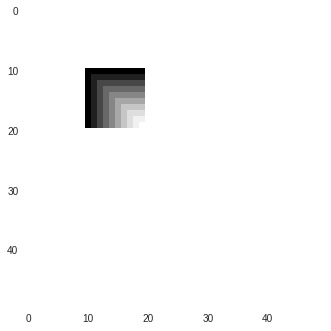

In [67]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

In [0]:
# edge-following
def leaves_shape(old_loc,new_loc):
  ans = False
  if old_loc in shape_coordinates:
    if new_loc not in shape_coordinates:
      ans = True
  return ans
  
def can_move(a,debug=False):
  neighbors = a['neighbors']
  (x0,y0) = a['true_coordinates']
  (dx,dy) = a['orientation']
  (x,y) = (x0+dx,y0+dy)

  ans = False
  occupied = [agents[neighbors[i]]['true_coordinates'] for i,d in enumerate(a['distances']) if d==1]
  if (x,y) not in occupied:
    if x in range(gridshape[0]) and y in range(gridshape[1]): # in grid
      if not leaves_shape((x0,y0),(x,y)): # doesn't leave shape
        needs_a_neighbor = [point for point in [(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x-1,y-1),(x-1,y+1),(x+1,y-1),(x+1,y+1)] if point != (x0,y0)]
        if any([(point in occupied) for point in needs_a_neighbor]): # doesn't isolate itself
          ans = True
          if debug:
            ans = [(x0,y0), (dx,dy), (x,y)]
  return ans

def update(a):
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)

def timestep(first_attempt_agent_index=0,agents=agents,shape_coordinates=shape_coordinates):
  
  if can_move(agents[first_attempt_agent_index]):
    selected_agent_index = first_attempt_agent_index
  else:
    movable_agents_not_in_shape = [i for i,a in enumerate(agents) if can_move(a) and a['estimated_coordinates'] not in shape_coordinates]
    selected_agent_index = random.choice(movable_agents_not_in_shape)
  
  selected_agent = agents[selected_agent_index]
  
  highlight_list = ['loc before move: '+str(selected_agent['true_coordinates'])]
  highlight_list = ['orientation before move: '+str(selected_agent['orientation'])]
  
  # move
  (x0,y0) = selected_agent['true_coordinates']
  (dx,dy) = selected_agent['orientation']
  selected_agent['true_coordinates'] = (x0+dx,y0+dy)
  
  highlight_list = highlight_list + ['loc after move: '+str(selected_agent['true_coordinates'])]
  
  old_neighbors = selected_agent['neighbors']
  update(selected_agent)
  new_neighbors = selected_agent['neighbors']
  
  highlight_list = highlight_list + ['loc after update: '+str(selected_agent['true_coordinates'])]
  
  move_tries = 0
  #clockwise_sequence = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
  clockwise_sequence = [(-1,0),(0,1),(1,0),(0,-1)]
  turn_sequence = [(turnx,turny) for (turnx,turny) in clockwise_sequence if (turnx+dx,turny+dy) != (0,0)]
  i = turn_sequence.index(selected_agent['orientation'])
  turn_sequence = [turn_sequence[(i+1)%3],turn_sequence[(i+2)%3],turn_sequence[i]]
    
  num_turns = 0
  while not can_move(selected_agent):
    selected_agent['orientation'] = turn_sequence[num_turns]
    num_turns += 1
    if num_turns == 3:
      break
     
  highlight_list = highlight_list + ['loc after turn: '+str(selected_agent['true_coordinates'])]
  highlight_list = highlight_list + ['orientation after turn: '+str(selected_agent['orientation'])]
  
  for i in list(set(old_neighbors).union(set(new_neighbors))):
    update(agents[i]) 
    
  debug_list = highlight_list + ['loc after neighbor updates: '+str(selected_agent['true_coordinates'])]
    
  return selected_agent_index, debug_list

def plot_grid(highlight_list=[]):
  grid = np.zeros((scaling_factor*L,scaling_factor*L))
  for s in shape_coordinates:
    grid[s]=0.5
  for a in agents:
    grid[a['true_coordinates']]=1
    
  for coordinates in highlight_list:
    grid[coordinates[0],coordinates[1]]=2
    
  plt.imshow(grid)
  plt.grid(False)
  plt.show()
  

t=0
['orientation before move: (-1, 0)', 'loc after move: (9, 10)', 'loc after update: (9, 10)', 'loc after turn: (9, 10)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (9, 10)']


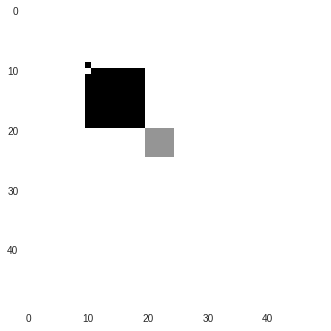

t=50
['orientation before move: (0, 1)', 'loc after move: (20, 16)', 'loc after update: (20, 16)', 'loc after turn: (20, 16)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (20, 16)']


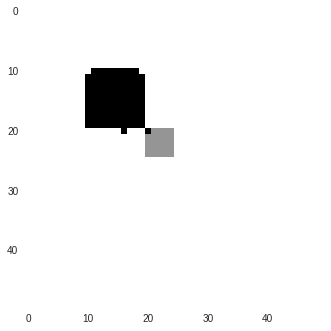

t=100
['orientation before move: (1, 0)', 'loc after move: (19, 20)', 'loc after update: (19, 20)', 'loc after turn: (19, 20)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (19, 20)']


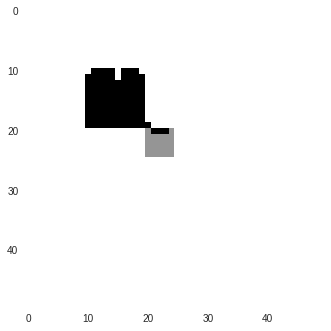

t=150
['orientation before move: (0, 1)', 'loc after move: (9, 19)', 'loc after update: (9, 19)', 'loc after turn: (9, 19)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (9, 19)']


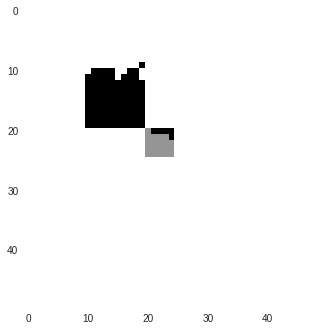

t=200
['orientation before move: (1, 0)', 'loc after move: (20, 9)', 'loc after update: (20, 9)', 'loc after turn: (20, 9)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (20, 9)']


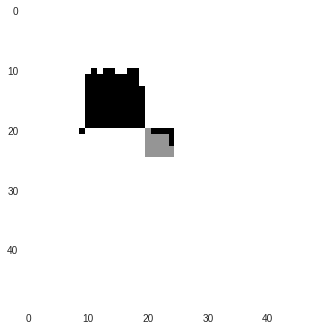

t=250
['orientation before move: (0, 1)', 'loc after move: (9, 19)', 'loc after update: (9, 19)', 'loc after turn: (9, 19)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (9, 19)']


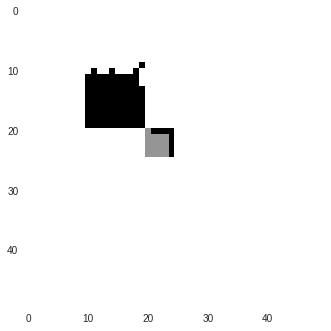

t=300
['orientation before move: (1, 0)', 'loc after move: (10, 17)', 'loc after update: (10, 17)', 'loc after turn: (10, 17)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (10, 17)']


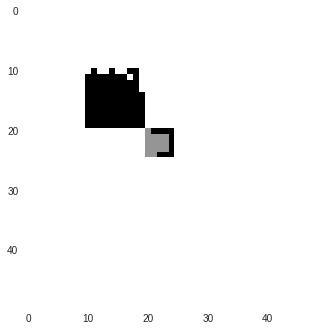

t=350
['orientation before move: (1, 0)', 'loc after move: (13, 9)', 'loc after update: (13, 9)', 'loc after turn: (13, 9)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (13, 9)']


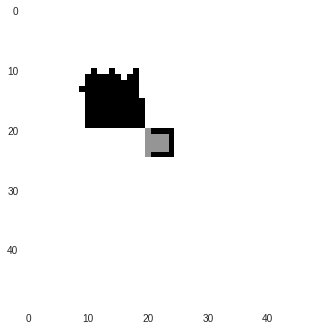

t=400
['orientation before move: (0, 1)', 'loc after move: (20, 15)', 'loc after update: (20, 15)', 'loc after turn: (20, 15)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (20, 15)']


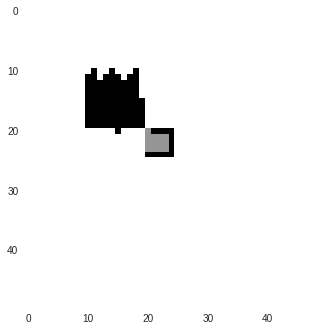

t=450
['orientation before move: (-1, 0)', 'loc after move: (13, 19)', 'loc after update: (13, 19)', 'loc after turn: (13, 19)', 'orientation after turn: (-1, 0)', 'loc after neighbor updates: (13, 19)']


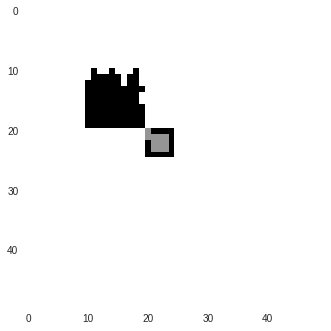

t=500
['orientation before move: (-1, 0)', 'loc after move: (21, 21)', 'loc after update: (21, 21)', 'loc after turn: (21, 21)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (21, 21)']


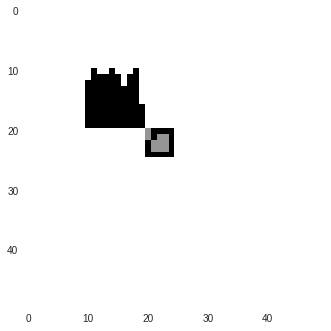

t=550
['orientation before move: (0, 1)', 'loc after move: (21, 23)', 'loc after update: (21, 23)', 'loc after turn: (21, 23)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (21, 23)']


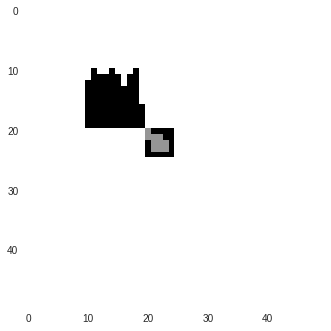

t=600
['orientation before move: (1, 0)', 'loc after move: (23, 23)', 'loc after update: (23, 23)', 'loc after turn: (23, 23)', 'orientation after turn: (0, -1)', 'loc after neighbor updates: (23, 23)']


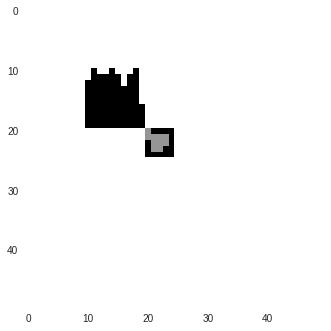

t=650
['orientation before move: (0, -1)', 'loc after move: (23, 21)', 'loc after update: (23, 21)', 'loc after turn: (23, 21)', 'orientation after turn: (-1, 0)', 'loc after neighbor updates: (23, 21)']


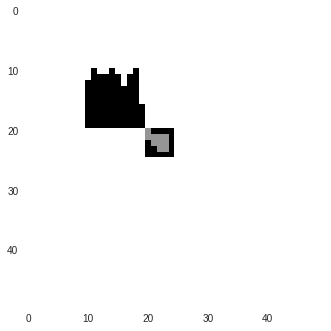

t=700
['orientation before move: (-1, 0)', 'loc after move: (21, 21)', 'loc after update: (21, 21)', 'loc after turn: (21, 21)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (21, 21)']


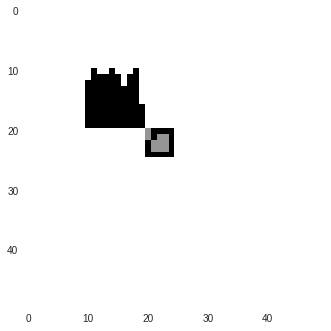

t=750
['orientation before move: (0, 1)', 'loc after move: (21, 23)', 'loc after update: (21, 23)', 'loc after turn: (21, 23)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (21, 23)']


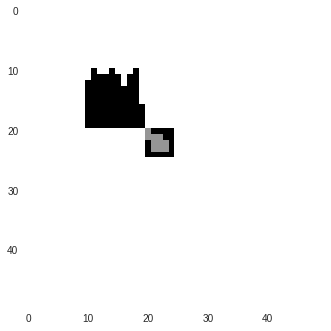

t=800
['orientation before move: (1, 0)', 'loc after move: (23, 23)', 'loc after update: (23, 23)', 'loc after turn: (23, 23)', 'orientation after turn: (0, -1)', 'loc after neighbor updates: (23, 23)']


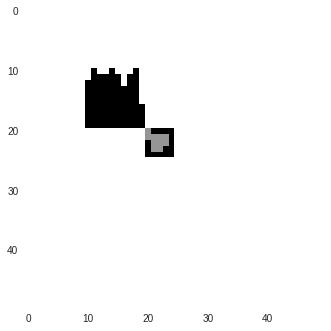

t=850
['orientation before move: (0, -1)', 'loc after move: (23, 21)', 'loc after update: (23, 21)', 'loc after turn: (23, 21)', 'orientation after turn: (-1, 0)', 'loc after neighbor updates: (23, 21)']


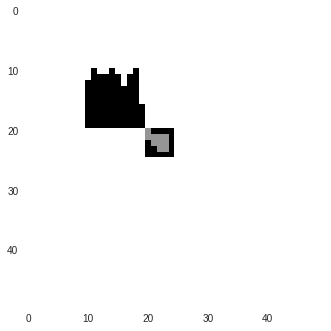

t=900
['orientation before move: (-1, 0)', 'loc after move: (21, 21)', 'loc after update: (21, 21)', 'loc after turn: (21, 21)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (21, 21)']


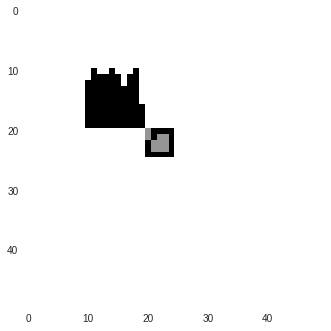

t=950
['orientation before move: (0, 1)', 'loc after move: (21, 23)', 'loc after update: (21, 23)', 'loc after turn: (21, 23)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (21, 23)']


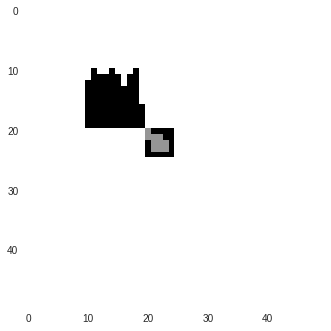

In [69]:
selected_agent_index = 0
for t in range(1000):
  selected_agent_index, debug_list = timestep(selected_agent_index)
  if t%50==0:
    print 't='+str(t)
    print debug_list
    plot_grid()